In [20]:
import re
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 21)
date_to = dt.date(2023, 6, 28)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)
battles = battles[battles["season"] == "Sizzle Season 2023"]
players = u.to_players(battles)

In [21]:
ability_cols = [x for x in players.columns if re.compile("^ability-.+").match(x)]
ability_cols = [x for x in ability_cols if x != "ability-ability_doubler"]

In [22]:
ability_mean = players.groupby(["mode", "weapon"])[ability_cols].mean()
ability_mean = ability_mean.groupby("weapon").mean()
ability_mean = ability_mean.rename(columns=lambda x: re.sub("^ability-", "", x))
ability_mean

,ink_saver_main,ink_saver_sub,ink_recovery_up,run_speed_up,swim_speed_up,special_charge_up,special_saver,special_power_up,quick_respawn,quick_super_jump,...,last_ditch_effort,tenacity,comeback,ninja_squid,haunt,thermal_ink,respawn_punisher,stealth_jump,object_shredder,drop_roller
weapon,,,,,,,,,,,,,,,,,,,,,
52gal,0.176644,0.144587,0.137620,0.169551,1.548178,0.215932,0.136972,0.083825,0.309899,0.273935,...,0.047128,0.004679,0.141980,0.475526,0.033169,0.003527,0.006768,0.623171,0.043195,0.026586
96gal,0.252115,0.155844,0.204701,0.181847,1.346677,0.369847,0.125340,0.197802,0.128146,0.246073,...,0.139479,0.000000,0.077292,0.115069,0.170208,0.000000,0.059479,0.442951,0.062500,0.023438
96gal_deco,0.368550,0.195760,0.206721,0.121121,1.017539,0.679526,0.218592,0.557898,0.095412,0.246912,...,0.048434,0.008070,0.065895,0.040490,0.031154,0.000000,0.002976,0.559013,0.041612,0.010086
bamboo14mk1,0.551774,0.402967,0.232814,0.660295,0.691664,0.636350,0.155638,0.152636,0.185073,0.277703,...,0.224916,0.026773,0.079453,0.079548,0.009532,0.052522,0.031017,0.265824,0.123399,0.021486
barrelspinner,0.167017,0.052861,0.080431,2.820697,0.327156,0.254822,0.082666,0.161835,0.034650,0.183220,...,0.047389,0.009498,0.004912,0.008468,0.010133,0.021301,0.012423,0.027284,0.164726,0.006040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tristringer,0.754899,0.238334,0.260468,0.659042,0.690311,0.703387,0.121291,0.179348,0.097211,0.331707,...,0.178483,0.022437,0.024050,0.015073,0.022484,0.268548,0.129546,0.051221,0.255275,0.021899
variableroller,0.593743,0.112512,0.165477,0.105217,0.941814,1.192754,0.227348,0.206310,0.137068,0.264868,...,0.167290,0.015835,0.083712,0.589934,0.003611,0.002907,0.011291,0.305700,0.012222,0.037966
wakaba,0.131068,2.231507,0.353093,0.095251,0.642098,0.357686,0.124094,0.048542,0.093264,0.138234,...,0.214269,0.002599,0.030953,0.097479,0.007025,0.003470,0.005063,0.110033,0.037422,0.014341


In [23]:
from sklearn.decomposition import PCA

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

df = ability_mean.reset_index()
df_z = df.iloc[:,1:].apply(standardize)
dimension = len(df_z.columns)
pc_cols = [f"pc{x+1}" for x in range(dimension)]

pca = PCA()
pca.fit(df_z)

# 各ブキの主成分を求める
score = pd.DataFrame(pca.transform(df_z), columns=pc_cols)
score = pd.concat([df.iloc[:,:1], score], axis=1)
score = score.set_index("weapon")

# 累積寄与率 cc_ratio を求める
ev_ratio = pd.DataFrame(pca.explained_variance_ratio_, index=pc_cols)
cc_ratio = ev_ratio.cumsum().T

# 主成分負荷量 eigen_vector を求める
eigen_vector = pd.DataFrame(pca.components_, columns=df_z.columns, index=pc_cols)

cc_ratio


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25
0,0.187805,0.316895,0.428389,0.518503,0.583276,0.636344,0.68749,0.731558,0.77484,0.813342,...,0.942896,0.95587,0.966153,0.975038,0.982888,0.989127,0.994234,0.997387,0.999983,1.0


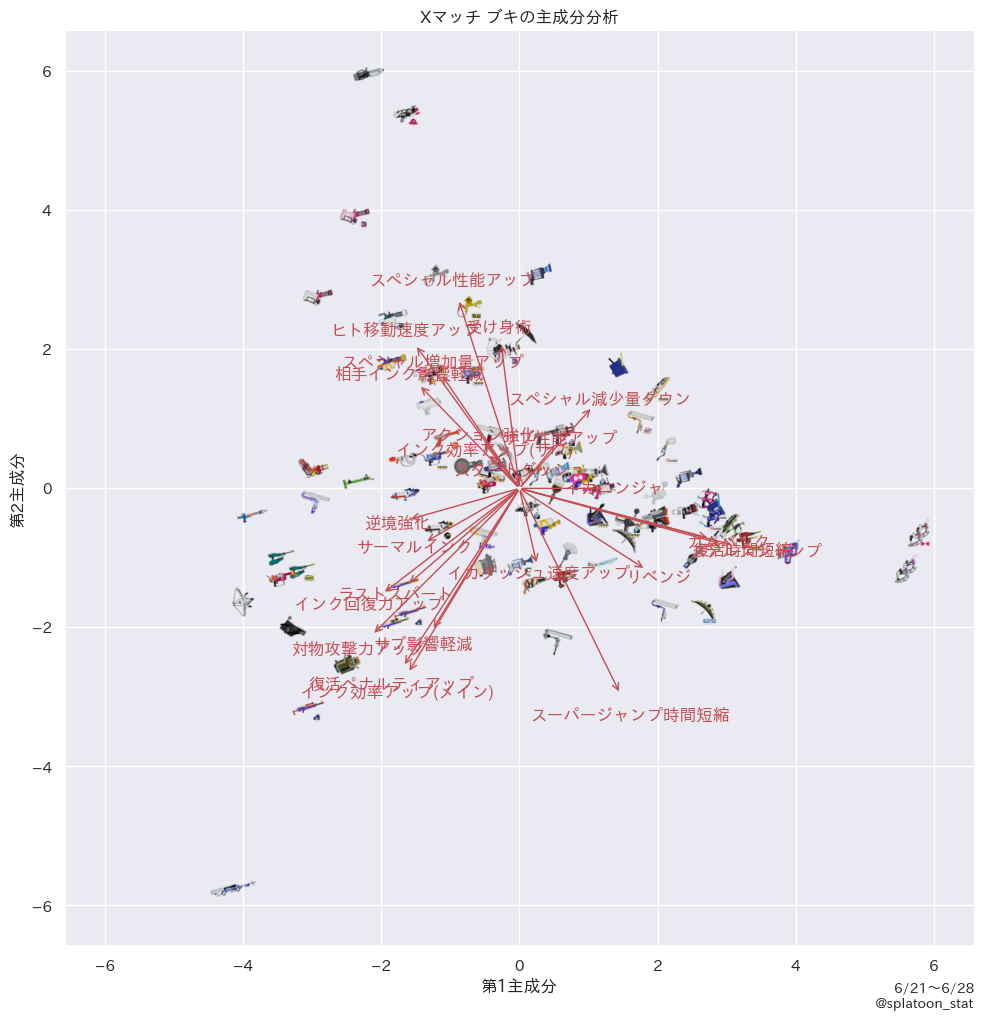

In [24]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} ブキの主成分分析", "Weapon PCA in ${lobby}")
i18n.add("pc1", "第1主成分", "1st component")
i18n.add("pc2", "第2主成分", "2nd component")

value_range = max(score[["pc1", "pc2"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=score,
    x="pc1",
    y="pc2",
    marker="",
    height=10,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("pc1"),
    ylabel=i18n.t("pc2"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, row in score.iterrows():
    weapon = row.name
    xvalue = row["pc1"]
    yvalue = row["pc2"]
    image_path = image.get_image_path(weapon)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
    ax.add_artist(ab)

for col, item in eigen_vector.items():
    mag = 8
    vec = [item["pc1"], item["pc2"]]
    ax.annotate("", (0, 0), xytext=[x * mag for x in vec], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(i18n.t(col), (0, 0), xytext=[x * mag * 1.1 for x in vec], color="r", ha="center", va="center")

u.credit(ax, g.fig, i18n.t_data_duration(battles))
plt.show()
